In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import comb
from sparse_rf.algs.core import min_wl2, min_l2
from sparse_rf.modules import make_X, make_W, make_A
from sparse_rf.util import *

In [2]:
m = 1000
d = 5
q = 2
active = fourier

ratio_train = 0.75

def make_D(W):
    norm = np.linalg.norm(W, axis=1)**2
    weight = np.concatenate((norm, norm), axis=-1)
    D = np.diag(1.0/weight**4)
    return D

In [3]:
X = make_X(d, m, dist=sphere)
X_train = X[:int(m*ratio_train), :]
X_test = X[int(m*ratio_train):, :]

In [4]:
b = np.zeros(d)
b[0] = 1
b[2] = 2
b /= np.linalg.norm(b)
y = np.matmul(X, b) + 0.1
y_train = y[:int(m*ratio_train)]
y_test = y[int(m*ratio_train):]

In [5]:
ns = np.arange(10, 500, 10)

# Dense features

## No ensemble

In [6]:
results_l2_dense = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, d, n*comb(d, q), dist=normal)]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_l2(A_train, y_train) for A_train in A_trains]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_l2_dense.append(res)

[1.9394120025568986e-05, 6.143847106785837e-07, 2.041353805436087e-07, 7.903786643643028e-08, 1.413633211081988e-07, 1.3601685328669208e-07, 1.7213618916495138e-07, 1.774222847779878e-07, 1.6428244369764954e-07, 2.099061012055673e-07, 2.2827806479035553e-07, 2.2755387539386023e-07, 2.313607917860638e-07, 2.486855882738601e-07, 2.540626541972494e-07, 2.704103518250899e-07, 2.7006964586063414e-07, 2.730651959556727e-07, 2.5226388240433606e-07, 2.8883017543393257e-07, 3.0060573399633587e-07, 2.7837545044192413e-07, 2.636447139947486e-07, 3.015062286728747e-07, 2.7475858158753095e-07, 2.8523566451165017e-07, 2.745395620442432e-07, 2.865965489446843e-07, 2.949519282202871e-07, 2.842505888664755e-07, 3.133252667282844e-07, 2.5959325871130674e-07, 3.3317429068066674e-07, 2.873487574564862e-07, 3.0248115081541774e-07, 3.208150483942376e-07, 2.593703094136866e-07, 3.1002231316969113e-07, 3.105748318343618e-07, 3.109164022347276e-07, 2.908093383068403e-07, 3.1286809588468895e-07, 3.1380084294600

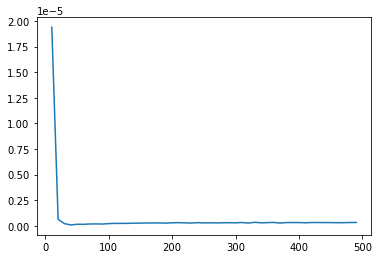

In [7]:
print([np.mean(res) for res in results_l2_dense])
plt.plot(ns, [np.mean(res) for res in results_l2_dense])

In [8]:
results_wl2_dense = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, d, n*comb(d, q), dist=normal)]
        Ds = [make_D(W) for W in Ws]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_wl2(A_train, y_train, D) for A_train, D in zip(A_trains, Ds)]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_wl2_dense.append(res)

[2.3274254815517215e-05, 6.547591776307117e-07, 1.5141988136057516e-07, 2.8100305027668098e-08, 1.056345831404485e-08, 5.504730892601995e-09, 2.68863008086481e-09, 1.585505153578665e-09, 1.3576317603796626e-09, 1.0521805822679734e-09, 9.078470980040805e-10, 7.33879251804283e-10, 7.775902941191768e-10, 4.559980868099351e-10, 5.153037991004357e-10, 4.673581664758624e-10, 4.565478133460429e-10, 4.842315667938344e-10, 4.721624351837868e-10, 4.591799865726532e-10, 3.1126372902100547e-10, 2.8472051644288676e-10, 3.012817358422524e-10, 2.4679615866370846e-10, 3.8537276662877523e-10, 5.061615366124676e-10, 3.3292656534815883e-10, 3.615007802541367e-10, 2.6886207736313706e-10, 3.2461374520143126e-10, 3.753405483979998e-10, 2.839329442553319e-10, 4.4974688394694185e-10, 3.345490464056666e-10, 3.199656208588367e-10, 2.884085723319544e-10, 3.121040392490781e-10, 5.966634386179437e-10, 3.9255313940518164e-10, 3.829802568059257e-10, 4.910794875338558e-10, 5.60126023826671e-10, 4.040794551417961e-10,

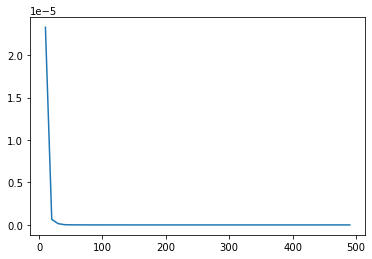

In [9]:
print([np.mean(res) for res in results_wl2_dense])
plt.plot(ns, [np.mean(res) for res in results_wl2_dense])

## Ensemble

In [10]:
results_l2_dense_ens = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, d, comb(d, q), dist=normal) for _ in range(n)]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_l2(A_train, y_train) for A_train in A_trains]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_l2_dense_ens.append(res)

[0.0015916979726510283, 0.00113581005628941, 0.001205236132927861, 0.0011827224746099592, 0.001102356848268312, 0.001158517818257343, 0.0011060589291933725, 0.0009732906133356215, 0.0009114777049808794, 0.0010132175308893094, 0.0009449639195898984, 0.0009688325075086183, 0.0009059029524062709, 0.0009385647354026002, 0.0008991510583128427, 0.000925141726942217, 0.000848936025847625, 0.0009017798944693494, 0.0009287362251403505, 0.0008995621069259786, 0.0009182788644828115, 0.0008834350414734588, 0.0008924305951681921, 0.0008920591257739665, 0.0008776507433754278, 0.0008802825978432075, 0.0008948988964916592, 0.000907888321379937, 0.0009243823463230442, 0.0008911369418620266, 0.0008987905904746859, 0.0009166623171474618, 0.0008883783854194378, 0.0008677354154078807, 0.0008487839449868254, 0.0009143801706363574, 0.0008969647923174357, 0.0008474690533040863, 0.0008680657821685884, 0.0008419547695491328, 0.0008349904448421372, 0.000905531890482349, 0.0008880397124901698, 0.00088857534853725

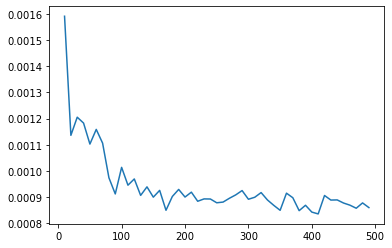

In [11]:
print([np.mean(res) for res in results_l2_dense_ens])
plt.plot(ns, [np.mean(res) for res in results_l2_dense_ens])

In [12]:
results_wl2_dense_ens = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, d, comb(d, q), dist=normal) for _ in range(n)]
        Ds = [make_D(W) for W in Ws]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_wl2(A_train, y_train, D) for A_train, D in zip(A_trains, Ds)]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_wl2_dense_ens.append(res)

[0.0016618430110125683, 0.0014996746973879485, 0.0012066106196460956, 0.001151189993135847, 0.00111326581687623, 0.0010394087834470138, 0.0010370340507201837, 0.0010992938177925783, 0.0010034157762913644, 0.0009623521294061849, 0.0010124478956564968, 0.0009662936514243323, 0.0010562432159140812, 0.0008687208399353668, 0.0008826706009572372, 0.0009439388382805804, 0.0009238519254312759, 0.0009150831999960843, 0.0009689504172745389, 0.0009119254070851006, 0.0009482381233352365, 0.000874658742727345, 0.0008872428321538703, 0.0008801095378141171, 0.0008858371905006337, 0.0008918431127026942, 0.0009016311319083382, 0.0009519283913642949, 0.0008901203271256481, 0.0009561987520352198, 0.0008615178956848191, 0.0009161810169479969, 0.0008606127353699329, 0.0008981723508327932, 0.0008865585213623836, 0.0008474389757207138, 0.0008858559531718033, 0.0008795073278646537, 0.0008732128148285867, 0.0009083438991151849, 0.0008481830906311546, 0.0008485194302988305, 0.0008835564001262314, 0.000909104777

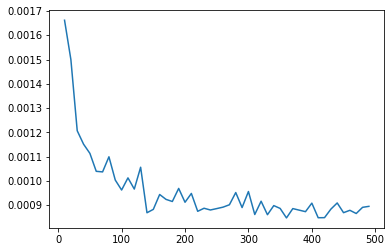

In [13]:
print([np.mean(res) for res in results_wl2_dense_ens])
plt.plot(ns, [np.mean(res) for res in results_wl2_dense_ens])

# Sparse features

## No ensemble

In [14]:
results_l2_sparse = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, q, n, dist=normal)]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_l2(A_train, y_train) for A_train in A_trains]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_l2_sparse.append(res)

[6.464408487495665e-09, 7.815224369234763e-07, 6.804141482403924e-05, 5.444522470263454e-05, 0.0001004053520803776, 4.102196085877648e-05, 5.6011693955240985e-05, 4.450327581702233e-05, 3.4974903336197044e-05, 2.5172907843018238e-05, 1.3682305422219756e-05, 1.1713226070926366e-05, 1.0762671372880399e-05, 6.896492198419029e-06, 6.4103141204611745e-06, 5.154583773813649e-06, 3.775648679509981e-06, 3.2303481499042677e-06, 2.665425098958144e-06, 2.379482220559922e-06, 2.263382946017735e-06, 2.1052898868107e-06, 1.2849846583203824e-06, 1.6931543380334012e-06, 1.3741641872813495e-06, 1.21564684791031e-06, 9.330502363301017e-07, 1.024762401097071e-06, 8.476312492438291e-07, 7.561254577888614e-07, 6.325443382207427e-07, 6.000495770547519e-07, 6.313606664768291e-07, 5.319042231860136e-07, 5.703167274592118e-07, 4.768028669155888e-07, 4.535864085547603e-07, 4.042521872563439e-07, 3.2098795798853215e-07, 4.2719834096898915e-07, 4.030951455998146e-07, 3.1775955889389864e-07, 2.979262397932049e-07,

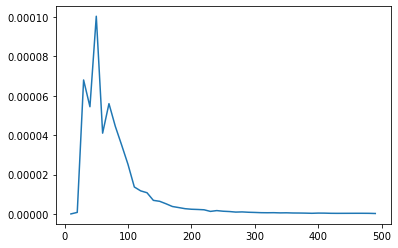

In [15]:
print([np.mean(res) for res in results_l2_sparse])
plt.plot(ns, [np.mean(res) for res in results_l2_sparse])

In [16]:
results_wl2_sparse = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, q, n, dist=normal)]
        Ds = [make_D(W) for W in Ws]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_wl2(A_train, y_train, D) for A_train, D in zip(A_trains, Ds)]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_wl2_sparse.append(res)

[8.14669962556888e-09, 8.55367393333003e-09, 1.1100815312958986e-08, 1.1493254480715904e-08, 4.278820847268765e-08, 1.0791661565532445e-07, 1.1253995887218303e-06, 6.367390004773651e-09, 9.434248681293163e-09, 2.3072831850047766e-07, 6.9486021037828066e-09, 8.384905628725369e-09, 8.168712647270293e-07, 4.049595123977967e-09, 1.0275985059745789e-08, 3.222450666854959e-08, 5.552166089707024e-08, 2.7606528511756236e-07, 1.957819005214197e-08, 6.927114745730865e-07, 1.934090421497359e-08, 1.3645823451563612e-07, 2.1565877424184145e-07, 3.158606800619058e-08, 5.008331282989674e-08, 5.856575886041232e-08, 2.5398680829599433e-08, 1.1312776173360984e-08, 5.898202329927163e-08, 7.642802753934364e-08, 3.101360536837538e-07, 1.6265524719215463e-06, 2.8055216509260646e-07, 8.693340813123809e-07, 6.949278406109478e-08, 6.31295842216583e-07, 3.359199682439574e-09, 1.1837863580878457e-07, 1.044655798258696e-07, 7.759908428169283e-08, 2.4044409343757915e-09, 1.6445960229495232e-07, 2.767887874265809e-

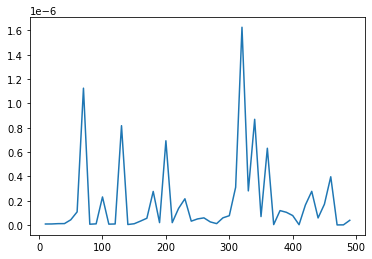

In [17]:
print([np.mean(res) for res in results_wl2_sparse])
plt.plot(ns, [np.mean(res) for res in results_wl2_sparse])

## Ensemble

In [18]:
results_l2_sparse_ens = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, q, 1, dist=normal) for _ in range(n)]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_l2(A_train, y_train) for A_train in A_trains]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_l2_sparse_ens.append(res)

[0.0006153094788583218, 0.00043138109578418575, 0.0004291525678860481, 0.00037902278544067774, 0.0004324512116389523, 0.00043186771474145087, 0.0003785157241589821, 0.00036696412447975133, 0.0003899617081407907, 0.000399273902898869, 0.00035791732161669874, 0.00036253414678085133, 0.00040121893809743345, 0.00037212474963306937, 0.00037114590126688526, 0.00036055334740734617, 0.00037162531064298106, 0.0003409116299496697, 0.00035311618775683314, 0.0003500116104846801, 0.000375774130885083, 0.000351743103522441, 0.00037204391331675443, 0.00035931275709479363, 0.00038827568323197045, 0.00037120024758943243, 0.00037513863293162216, 0.00036838317133576227, 0.000374635000610729, 0.00037161096748291374, 0.00036560660551901734, 0.00035197886292950966, 0.00035967761953341787, 0.00034452215178812823, 0.00035356672397795683, 0.0003530548707057127, 0.00037365287790556506, 0.0003581913266960175, 0.0003467199337892587, 0.00037674279008689815, 0.0003690115388450974, 0.00035775997597078685, 0.00035135

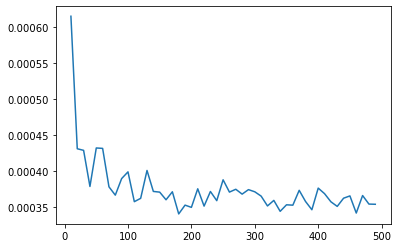

In [19]:
print([np.mean(res) for res in results_l2_sparse_ens])
plt.plot(ns, [np.mean(res) for res in results_l2_sparse_ens])

In [20]:
results_wl2_sparse_ens = []
for n in ns:
    res = []
    for _ in range(5):
        Ws = [make_W(d, q, 1, dist=normal) for _ in range(n)]
        Ds = [make_D(W) for W in Ws]
        A_trains = [make_A(X_train, W, active=active) for W in Ws]
        A_tests = [make_A(X_test, W, active=active) for W in Ws]
        cs = [min_wl2(A_train, y_train, D) for A_train, D in zip(A_trains, Ds)]
        y_pred = np.mean(np.array([A_tests[i]@cs[i] for i in range(len(Ws))]), axis=0)
        res.append(np.linalg.norm(y_pred-y_test) / len(y_test))

    results_wl2_sparse_ens.append(res)

[0.0005531563318985562, 0.00045121112287149594, 0.0003882660247845192, 0.0004255951619997091, 0.00046319681669004223, 0.0004001929107799988, 0.00039781260509054884, 0.00037503511166557074, 0.0004037769758796346, 0.00033568105568934127, 0.0003895176642445197, 0.00038441770760164803, 0.00040446259730809433, 0.0003611448156854975, 0.00041490879760338847, 0.0003804825814964543, 0.00033175394760391895, 0.0003811999336187745, 0.00037984269542908273, 0.0003350802163449665, 0.00036535590404309395, 0.00037484049370682963, 0.0003638444004050058, 0.00038645387484234704, 0.0003557476934125738, 0.0003567499876488711, 0.0003840548409555512, 0.0003638065144029863, 0.0003867436447277616, 0.0003807148610441456, 0.00037059257426164946, 0.00036874339083027064, 0.00036677395321269333, 0.0003710403844936485, 0.00037615998322080007, 0.0003685648052591917, 0.00035935059124134574, 0.00037317707362072695, 0.00037933861755494556, 0.00037155278599763605, 0.0003617742689007667, 0.00036945240456846254, 0.000364397

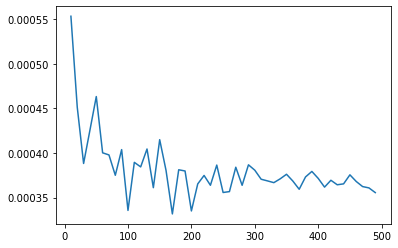

In [21]:
print([np.mean(res) for res in results_wl2_sparse_ens])
plt.plot(ns, [np.mean(res) for res in results_wl2_sparse_ens])